In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import scipy.stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import urllib
import requests
import zipfile
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
from sklearn.decomposition import PCA
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from fiona.crs import from_epsg
import os
from astropy.stats import median_absolute_deviation
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import cross_val_score
from factor_analyzer import FactorAnalyzer

Populating the interactive namespace from numpy and matplotlib


In [4]:
data = pd.read_csv('DATA/BKtotalv2class1.csv')

In [5]:
data.head()

,Unnamed: 0,GEOID,pickups_intract,NYPDfelony,units,perSQFTvalueC1,newperSQFTvalueC1,Pop_Den,Median_Household_Income,Gini_Index,Ave_Commute_Min,Unemployed_rate_16,Moved_after_2010
0,1,36047000100,102138.80700,26,106.0,1190.616338,1459.290687,49889.94,70938,0.5568,33,0.041451,0.267808
1,2,36047000200,21497.86679,84,NaN,243.786509,313.939797,16619.20,34740,0.4267,38,0.079075,0.254157
2,3,36047000301,96582.50072,46,NaN,NaN,NaN,48017.63,101544,0.5830,31,0.030144,0.319527
3,4,36047000501,39175.79425,17,62.0,NaN,NaN,147218.90,110700,0.5084,30,0.070352,0.369855
4,5,36047000502,45341.36746,38,NaN,1317.588974,1528.943303,69557.17,91964,0.5410,30,0.078696,0.304762


In [6]:
data.units = data.units.replace(np.nan,0)

In [7]:
data = data.drop(['Unnamed: 0'],axis=1)

In [8]:
data.head(3)

,GEOID,pickups_intract,NYPDfelony,units,perSQFTvalueC1,newperSQFTvalueC1,Pop_Den,Median_Household_Income,Gini_Index,Ave_Commute_Min,Unemployed_rate_16,Moved_after_2010
0,36047000100,102138.80700,26,106.0,1190.616338,1459.290687,49889.94,70938,0.5568,33,0.041451,0.267808
1,36047000200,21497.86679,84,0.0,243.786509,313.939797,16619.20,34740,0.4267,38,0.079075,0.254157
2,36047000301,96582.50072,46,0.0,NaN,NaN,48017.63,101544,0.5830,31,0.030144,0.319527


In [9]:
TRACT = gpd.GeoDataFrame.from_file('DATA/gz_2010_36_140_00_500k/gz_2010_36_140_00_500k.shp')

In [10]:
TRACT.GEO_ID = TRACT.GEO_ID.str[9:]

In [11]:
data.GEOID = data.GEOID.astype('str')

In [12]:
data = pd.merge(TRACT,data,left_on='GEO_ID',right_on='GEOID')

In [13]:
data.TRACT = data.TRACT.astype('int64')

In [14]:
NTA = pd.read_csv('DATA/2010CensusTract_PUMA_NTA(1).csv')

In [15]:
NTA = NTA[NTA['Borough'] == 'Brooklyn']

In [16]:
data = pd.merge(data,NTA,left_on='TRACT',right_on='2010CensusTract')

In [17]:
data.groupby('PUMA').median()['pickups_intract'][4001]

50115.333734999993

In [18]:
def median_interpolation(data,columns):
    for column in columns:
        for i in range(len(data.index)):
            if np.isnan(data[column][i]):
                data[column][i] = data.groupby('PUMA').median()[column][data['PUMA'][i]] 
    return data

In [19]:
data.columns[9:20]

Index(['pickups_intract', 'NYPDfelony', 'units', 'perSQFTvalueC1',
       'newperSQFTvalueC1', 'Pop_Den', 'Median_Household_Income', 'Gini_Index',
       'Ave_Commute_Min', 'Unemployed_rate_16', 'Moved_after_2010'],
      dtype='object')

In [20]:
data = median_interpolation(data,data.columns[9:20])

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [21]:
data.isnull().sum()

GEO_ID                     0
STATE                      0
COUNTY                     0
TRACT                      0
NAME                       0
LSAD                       0
CENSUSAREA                 0
geometry                   0
GEOID                      0
pickups_intract            0
NYPDfelony                 0
units                      0
perSQFTvalueC1             0
newperSQFTvalueC1          0
Pop_Den                    0
Median_Household_Income    0
Gini_Index                 0
Ave_Commute_Min            0
Unemployed_rate_16         0
Moved_after_2010           0
Borough                    0
2010CensusTract            0
PUMA                       0
NTA_Code                   0
NTA_Name                   0
dtype: int64

## Normalization

In [22]:
data.columns[9:20]

Index(['pickups_intract', 'NYPDfelony', 'units', 'perSQFTvalueC1',
       'newperSQFTvalueC1', 'Pop_Den', 'Median_Household_Income', 'Gini_Index',
       'Ave_Commute_Min', 'Unemployed_rate_16', 'Moved_after_2010'],
      dtype='object')

In [23]:
def norm(data,columns):
    for x in columns:
        data[x] = (data[x]-np.min(data[x]))/(np.max(data[x])-np.min(data[x]))
    return data

In [24]:
data = norm(data,data.columns[9:20])

In [25]:
data.head(1)

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry,GEOID,pickups_intract,NYPDfelony,units,perSQFTvalueC1,newperSQFTvalueC1,Pop_Den,Median_Household_Income,Gini_Index,Ave_Commute_Min,Unemployed_rate_16,Moved_after_2010,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name
0,36047010400,36,047,10400,104,Tract,0.059,"POLYGON ((-74.01115399999999 40.637404, -74.01...",36047010400,0.019185,0.110075,0.0,0.228848,0.193397,0.619398,0.141055,0.419984,0.403846,0.175398,0.333929,Brooklyn,10400,4012,BK34,Sunset Park East


## Outliers

In [26]:

def clean(data,columns):
    for x in columns:
        #data= data[(np.abs(data[x]-np.median(data[x]))/(np.median(np.abs(data[x]-np.median(data[x])))/0.6745)) < 2.24]
        data = data[(data[x]<np.mean(data[x])+4*np.std(data[x]))&(data[x]>np.mean(data[x])-4*np.std(data[x]))]
    return data

In [27]:
data = clean(data,data.columns[9:20])

In [28]:
data.shape

(704, 25)

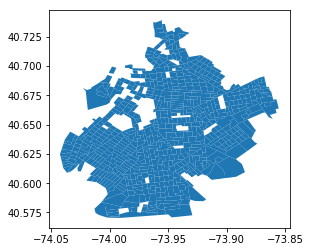

In [29]:
data.plot()

## PCA

In [141]:
X_num = data[data.columns[9:20]].drop(['units','perSQFTvalueC1','newperSQFTvalueC1'],axis=1)
pca = PCA(0.90)
Xproj = pca.fit_transform(X_num)

In [142]:
pca.explained_variance_ratio_

array([ 0.31878609,  0.21074858,  0.18507933,  0.11457502,  0.07700643])

In [143]:
components_explanation = pd.DataFrame(pca.components_,columns = X_num.columns)
components_explanation

,pickups_intract,NYPDfelony,Pop_Den,Median_Household_Income,Gini_Index,Ave_Commute_Min,Unemployed_rate_16,Moved_after_2010
0,0.022872,0.139519,0.524210,-0.416655,0.686662,-0.120681,0.148490,0.153285
1,-0.053464,0.081182,0.677213,-0.162360,-0.599609,0.364738,0.101848,0.051331
2,-0.207661,0.055894,-0.332415,-0.368765,0.173434,0.675705,0.265419,-0.387507
3,-0.237787,-0.305513,0.247022,-0.101730,-0.027523,-0.354394,-0.182288,-0.786873
4,-0.084122,-0.332352,0.282136,0.602756,0.364678,0.481946,-0.272552,-0.001572


## FA

In [120]:
fa = FactorAnalyzer()

In [161]:
fa.analyze(X_num,4,rotation='varimax')

In [162]:
fa.get_communalities()

,Communalities
pickups_intract,0.797573
NYPDfelony,0.475974
Pop_Den,0.332663
Median_Household_Income,0.781660
Gini_Index,0.323391
Ave_Commute_Min,0.536534
Unemployed_rate_16,0.476885
Moved_after_2010,0.394284


In [163]:
fa.loadings

,Factor1,Factor2,Factor3,Factor4
pickups_intract,0.010218,0.879055,0.095660,0.124820
NYPDfelony,0.548499,0.368355,0.101011,-0.170983
Pop_Den,0.081502,0.098470,0.099506,-0.553555
Median_Household_Income,-0.509202,0.271541,-0.447103,0.498736
Gini_Index,0.133993,0.033913,0.537357,-0.124635
Ave_Commute_Min,0.480726,-0.315555,-0.453679,-0.006057
Unemployed_rate_16,0.677214,-0.009846,0.115215,-0.069964
Moved_after_2010,0.010186,0.573536,-0.005950,-0.255345


In [164]:
fa.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4
SS Loadings,1.274659,1.421619,0.737044,0.685642
Proportion Var,0.159332,0.177702,0.092131,0.085705
Cumulative Var,0.159332,0.337035,0.429165,0.514871


In [125]:
fa.loadings[np.abs(fa.loadings['Factor1'])>0.5]['Factor1']

NYPDfelony                 0.548499
Median_Household_Income   -0.509202
Unemployed_rate_16         0.677214
Name: Factor1, dtype: float64

In [126]:
for column in fa.loadings:
    print(column+':\n')
    print(fa.loadings[np.abs(fa.loadings[column])>0.3][column])
    print('\n')

Factor1:

NYPDfelony                 0.548499
Median_Household_Income   -0.509202
Ave_Commute_Min            0.480726
Unemployed_rate_16         0.677214
Name: Factor1, dtype: float64


Factor2:

pickups_intract     0.879055
NYPDfelony          0.368355
Ave_Commute_Min    -0.315555
Moved_after_2010    0.573536
Name: Factor2, dtype: float64


Factor3:

Median_Household_Income   -0.447103
Gini_Index                 0.537357
Ave_Commute_Min           -0.453679
Name: Factor3, dtype: float64


Factor4:

Pop_Den                   -0.553555
Median_Household_Income    0.498736
Name: Factor4, dtype: float64


